Dataset shape: (115298, 10)

Column names:
['time', 'shunt_voltage', 'bus_voltage_V', 'current_mA', 'power_mW', 'State', 'Attack', 'Attack-Group', 'Label', 'interface']

First few rows:
               time  shunt_voltage  bus_voltage_V  current_mA  power_mW State  \
0  12/25/2023 22:35            978          5.165        1027      5300  idle   
1  12/25/2023 22:35            872          5.161        1009      4980  idle   
2  12/25/2023 22:35           1017          5.165        1029      5300  idle   
3  12/25/2023 22:35            930          5.161        1005      5180  idle   
4  12/25/2023 22:35            958          5.165        1034      5180  idle   

      Attack Attack-Group   Label interface  
0  syn-flood          DoS  attack      ocpp  
1  syn-flood          DoS  attack      ocpp  
2  syn-flood          DoS  attack      ocpp  
3  syn-flood          DoS  attack      ocpp  
4  syn-flood          DoS  attack      ocpp  

Data types:
time              object
shunt_voltage

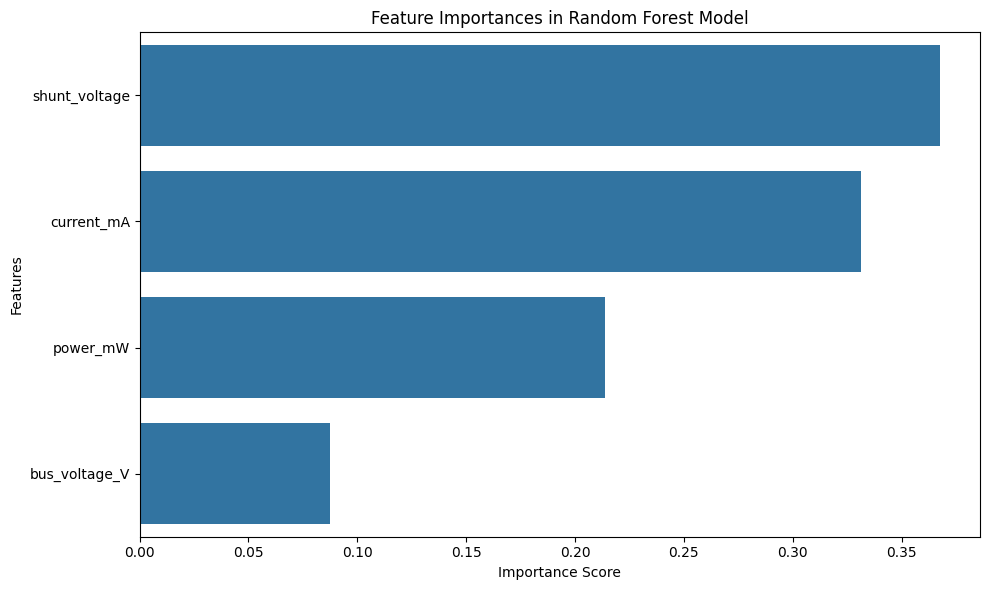

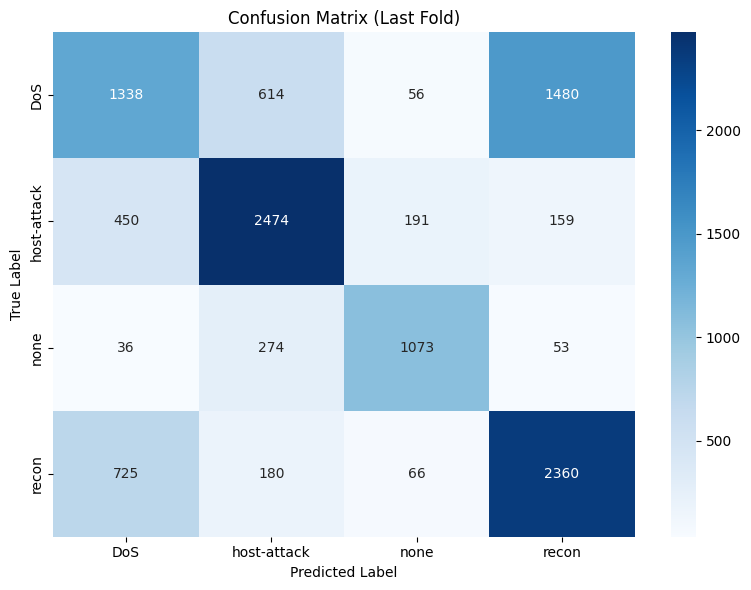


CLASSIFICATION REPORT (Last Fold)
              precision    recall  f1-score   support

         DoS       0.52      0.38      0.44      3488
 host-attack       0.70      0.76      0.73      3274
        none       0.77      0.75      0.76      1436
       recon       0.58      0.71      0.64      3331

    accuracy                           0.63     11529
   macro avg       0.64      0.65      0.64     11529
weighted avg       0.62      0.63      0.62     11529



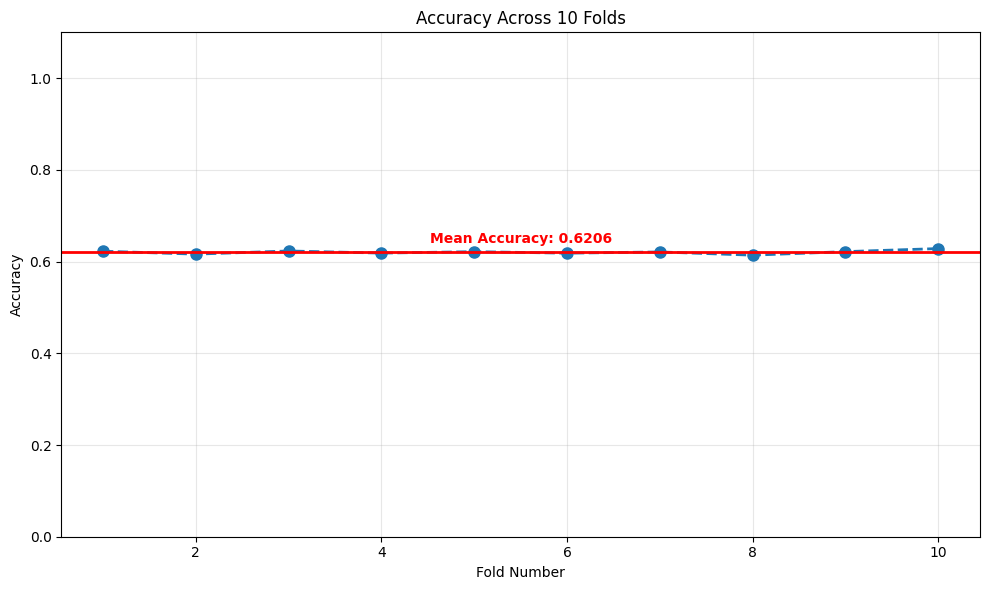

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# Load the dataset
data = pd.read_csv('EVSE-B-PowerCombined.csv')

# Display basic info about the dataset
print("Dataset shape:", data.shape)
print("\nColumn names:")
print(data.columns.tolist())
print("\nFirst few rows:")
print(data.head())
print("\nData types:")
print(data.dtypes)

# Check for any non-numeric values in the feature columns
feature_columns = ['current_mA', 'shunt_voltage', 'power_mW', 'bus_voltage_V'] # for top 4 best
# feature_columns = ['time','current_mA', 'shunt_voltage'] # for top 3 best

# feature_columns = ['interface', 'Attack_Group', 'time', 'Attack']

print("\nChecking for non-numeric values in feature columns:")
for col in feature_columns:
    if col in data.columns:
        # Check data type
        print(f"\n{col}:")
        print(f"  Data type: {data[col].dtype}")

        # If it's object type, show unique values (first 10)
        if data[col].dtype == 'object':
            print(f"  Unique values (first 10): {data[col].unique()[:10]}")

        # Check for null values
        print(f"  Null values: {data[col].isnull().sum()}")
    else:
        print(f"Column '{col}' not found in dataset")

# Clean and prepare the data
def clean_numeric_column(series):
    """Convert a series to numeric, handling errors"""
    # Try to convert to numeric, errors='coerce' will turn invalid values to NaN
    numeric_series = pd.to_numeric(series, errors='coerce')
    return numeric_series

# Select and clean features
X_columns = []
for col in feature_columns:
    if col in data.columns:
        X_columns.append(col)

if not X_columns:
    print("Error: None of the specified feature columns found in the dataset")
    print("Available columns:", data.columns.tolist())
    exit()

# Create feature matrix with cleaned data
X = data[X_columns].copy()

# Clean each column
for col in X.columns:
    X[col] = clean_numeric_column(X[col])

print(f"\nFeature matrix shape after cleaning: {X.shape}")
print("Features being used:", X.columns.tolist())

# Check for and handle missing values
print(f"\nMissing values per column:")
print(X.isnull().sum())

# Remove rows with any missing values in features
initial_rows = len(X)
mask = X.notnull().all(axis=1)
X = X[mask]

# Also filter the target variable
# if 'Label' in data.columns:
#     y = data['Label'][mask]
# else:
#     print("Error: 'Label' column not found in dataset")
#     print("Available columns:", data.columns.tolist())
#     exit()
#
# print(f"Rows removed due to missing values: {initial_rows - len(X)}")
# print(f"Final dataset shape: {X.shape}")

if 'Attack-Group' in data.columns:
    y = data['Attack-Group'][mask]
else:
    print("Error: 'Attack-Group' column not found in dataset")
    print("Available columns:", data.columns.tolist())
    exit()

print(f"Rows removed due to missing values: {initial_rows - len(X)}")
print(f"Final dataset shape: {X.shape}")

# Check target variable
print(f"\nTarget variable info:")
print(f"Unique values: {y.unique()}")
print(f"Value counts:\n{y.value_counts()}")

# Ensure we have enough data for cross-validation
if len(X) < 10:
    print("Error: Not enough data for 10-fold cross-validation")
    exit()

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

try:
    # Perform cross-validation and get scores
    cv_scores = cross_val_score(rf_classifier, X, y, cv=cv, scoring='accuracy')

    # Print cross-validation results
    print("\n" + "="*50)
    print("CROSS-VALIDATION RESULTS")
    print("="*50)
    print("Cross-Validation Scores:", [f"{score:.4f}" for score in cv_scores])
    print("Mean Accuracy: {:.2f}%".format(np.mean(cv_scores) * 100))
    print("Standard Deviation: {:.2f}%".format(np.std(cv_scores) * 100))

    # Train the model on the entire dataset for visualization
    rf_classifier.fit(X, y)

    # Get feature importances
    feature_importances = rf_classifier.feature_importances_
    features = X.columns

    # Create a DataFrame for feature importances
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values('Importance', ascending=False)

    print("\nFeature Importances:")
    for idx, row in importance_df.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importances in Random Forest Model')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

    # For confusion matrix visualization (using last fold as example)
    # Split data into train and test for the last fold
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train on this split and predict
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Get unique labels for confusion matrix
    unique_labels = sorted(y.unique())

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=unique_labels,
                yticklabels=unique_labels)
    plt.title('Confusion Matrix (Last Fold)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\n" + "="*50)
    print("CLASSIFICATION REPORT (Last Fold)")
    print("="*50)
    print(classification_report(y_test, y_pred))

    # Plot accuracy across folds
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), cv_scores, marker='o', linestyle='--', linewidth=2, markersize=8)
    plt.title('Accuracy Across 10 Folds')
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.1)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=np.mean(cv_scores), color='r', linestyle='-', linewidth=2)
    plt.text(5.5, np.mean(cv_scores)+0.02, f'Mean Accuracy: {np.mean(cv_scores):.4f}',
             color='r', ha='center', fontweight='bold')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("Please check your data and column names.")